In [17]:
import sys
sys.path.append('./.local/lib/python3.8/site-packages')
sys.path.append('/usr/lib/python3/dist-packages')

In [16]:
import zipfile

zipf = zipfile.ZipFile('ECG_adult_numpy_train.zip')
zipf.extractall('dataset/ECG_adult_numpy_train')

In [53]:
import shutil

shutil.move('dataset/ECG_adult_numpy_train/ECG_adult_numpy_train2', 'dataset')

'dataset/ECG_adult_numpy_train2'

# Preprocess

## Filters

In [1]:
import sys
sys.path.append('./.local/lib/python3.8/site-packages')
sys.path.append('/usr/lib/python3/dist-packages')

import itertools as it
import os
import pandas as pd
import numpy as np
import random
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm
import time, datetime
import neurokit2 as nk
from tqdm import tqdm

SRATE = 500

def ECG_filter(seg, method, srate):
    if method == 'bandpass':
        import scipy.signal
        sos = scipy.signal.butter(3, [1,47], 'bandpass', output='sos', fs=srate)
        return scipy.signal.sosfilt(sos, seg)
    # lowess랑 수학적으로 동일한데 더 빠름 - 대신 계수 체크 필요
    elif method == 'savgol':
        import scipy.signal
        return seg - scipy.signal.savgol_filter(seg, 1151, 3)
    
    elif method == 'lowess':
        import statsmodels.api as sm
        x = np.arange(0, len(seg))
        return seg - sm.nonparametric.lowess(seg, x, frac=0.2, it=0)[:, 1].T

    else:
        print('not a valid filter')
        return seg

In [2]:
SRATE = 500
QRS_TIME_WINDOW = [-0.25, 0.15]
DURATION = 10

def hr_cal(ecg_clean, srate=SRATE, timespan=QRS_TIME_WINDOW):
    ecg_pantompkins = nk.ecg_clean(ecg_clean, srate=srate, method='pantompkins', powerline=60)
    r_peaks = nk.ecg_findpeaks(ecg_pantompkins, srate=srate, method='pantompkins')
    r_peaks = r_peaks['ECG_R_Peaks']
    
    sample_span = np.array([int(val * srate) for val in timespan])
    r_peaks_LMS = []

    for r_peak in r_peaks:
        local = r_peak + sample_span
        if local[0] < 0 or local[1] > srate * DURATION: continue

        ecg_local = ecg_clean[local[0]:local[1]]
        r_peaks_LMS.append(local[0] + np.argmax(ecg_local))
        
    if len(r_peaks_LMS) <= 3:
        return -1
    interval = (r_peaks_LMS[-2] - r_peaks_LMS[1]) / (len(r_peaks_LMS)-3)

    return 60 / interval * SRATE

## Codes

### train

In [ ]:
TRAIN = 'train'
ADULT = 'child'
NORM = 'z-norm'
LEADS = np.arange(12)

file_path = f'dataset/ECG_{ADULT}_numpy_{TRAIN}'
ECG_FILT = 'bandpass'

# path for cache
if not os.path.exists('cache'):
    os.mkdir('cache')     
if not os.path.exists('cache/preprocess'):
    os.mkdir('cache/preprocess')

hyper_path = f'SRATE{SRATE}_ECG-{ECG_FILT}_{NORM}_{ADULT}_{TRAIN}/'
input_path = f"dataset/{hyper_path}/"
if not os.path.exists(input_path[:-1]):
    os.mkdir(input_path[:-1])  


# dataframe to save preprocessing info
column_list = ['caseid', 'gender', 'age', 'hr'] + [f'{i+1}' for i in LEADS]
df_preprocess = pd.DataFrame(columns = column_list)

# df_preprocess에 demographs(age, gender) 추가
df_demo = pd.read_csv(f'ECG_{ADULT}_age_{TRAIN}.csv')
caseids = df_demo['FILENAME'].values


# set variables
caseids = os.listdir(file_path)
#initial, interval = f_num, len(caseids)

# variables
x, y, c, g = [], [] ,[], [] # x(ECG), y(age), c(caseid), g(gender)

#pbar = tqdm(caseids[initial:initial+interval])
for idx, row in tqdm(df_demo[0:].iterrows(), total=df_demo.shape[0]):
    caseid = row['FILENAME']

    ecg = np.load(f'{file_path}/{caseid}.npy')

    #dataframe에 새로운 행 만들기
    df_preprocess.loc[idx,'caseid'] = caseid
    df_preprocess.loc[idx, 'age'] = row['AGE']
    df_preprocess.loc[idx, 'gender'] = row['GENDER']

    x_ind = []
    cnt = 0
    
    # lead II로 hr 계산 -> 이상한 데이터 제거
    seg_ecg = ecg[5000*1:5000*2]
    seg_ecg = ECG_filter(pd.DataFrame(seg_ecg).fillna(method='ffill', axis=0).fillna(method='bfill', axis=0).values.flatten(), method=ECG_FILT, srate=SRATE)
    
    hr = hr_cal(seg_ecg)
    df_preprocess.loc[idx,'hr'] = hr

    if (hr < 30) or (hr > 200):
        df_preprocess.loc[idx,f'{lead+1}'] = (False, nan_info, -3)
        continue
        
    # 각 lead마다 input 뽑기
    for lead in range(12):
        seg_ecg = ecg[5000*lead:5000*(lead+1)]

        # signal outliers
        #seg_ecg = [np.nan if ele <=-5 else ele for ele in ecg]

     
        if len(np.unique(seg_ecg)) == 1:
            df_preprocess.loc[idx,f'{lead+1}'] = (False, nan_info, -1)
            continue

        
        ## 1. 결측치 제거 ##
        nan_info = np.mean(np.isnan(seg_ecg))

        # 결측치가 많은 경우, noise 확인할 것도 없이 False -  이 경우의 noise_info는 -1로 처리
        if nan_info > 0.05:
            #print(' too much missing data', end='...')
            df_preprocess.loc[idx,f'{lead+1}'] = (False, nan_info, -1)
            continue

            
        ## 2. Denosing ##
        # ECG : 1-40Hz bandpass filter / PPG : loess filter
        seg_ecg = ECG_filter(pd.DataFrame(seg_ecg).fillna(method='ffill', axis=0).fillna(method='bfill', axis=0).values.flatten(), method=ECG_FILT, srate=SRATE)


        # 이 segment의 정보를 dataframe에 저장 - (전처리 성공여부, 전처리 nan 비율, 전처리 noise 비율, 통증 점수)
        df_preprocess.loc[idx,f'{lead+1}'] = (True, nan_info, 1)
        cnt += 1
        #print(f'preprocessing done...{bool_pass[0]}', end='')


        # normalize the signal into the range of -1 to 1
        #ecg_input = 2 * (seg_ecg - np.min(seg_ecg)) / (np.max(seg_ecg) - np.min(seg_ecg)) - 1
        ecg_input = stats.zscore(seg_ecg)

        x_ind.append(ecg_input)

    # merging total leads data
    if cnt == 12:
        y.append((row['AGE']))
        if row['GENDER']=='FEMALE':
            g.append(0)
        else:
            g.append(1)
        x.append(x_ind)
        c.append(caseid)


            
print(f'\ndumping cache of df_preprocess {idx}/{len(caseids)}', end='...')
df_preprocess.reset_index(drop=True, inplace=True)    
pickle.dump(df_preprocess, open(f'cache/preprocess/df_preprocess_{hyper_path[:-1]}', 'wb'))
print('dumping success')

# dataset
x = np.array(x, np.float32)
x = x.transpose((0,2,1))
y = np.array(y, np.float32)
c = np.array(c)
g = np.array(g, int)


print('after concatenate + transpose')
print('x shape:', x.shape)
print('y shape:', y.shape)
print('caseid num: ', len(c))
print(f'input path: {input_path}\n')

 20%|██        | 1776/8781 [00:32<02:07, 55.04it/s]

In [ ]:
caseid_train = pickle.load(open(f'dataset/caseid_{ADULT}_train', 'rb'))
caseid_test = pickle.load(open(f'dataset/caseid_{ADULT}_test', 'rb'))

train_mask = np.isin(c, caseid_train)
test_mask = np.isin(c, caseid_test)

x_train = x[train_mask]
x_test = x[test_mask]
y_train = y[train_mask]
y_test = y[test_mask]
g_train = g[train_mask]
g_test = g[test_mask]
c_train = c[train_mask]
c_test = c[test_mask]



print(f'x train shape: {x_train.shape}')
print(f'x test shape: {x_test.shape}')


# 저장하기
input_path = f'dataset/{hyper_path}'
print('saving...', end='', flush=True)
np.savez_compressed(input_path+'/x.npz', x_train=x_train, x_test=x_test)
np.savez_compressed(input_path+'/y.npz', y_train=y_train, y_test=y_test)
np.savez_compressed(input_path+'/c.npz', c_train=c_train, c_test=c_test)
np.savez_compressed(input_path+'/g.npz', g_train=g_train, g_test=g_test)
print('completed')

### previous

In [ ]:
TRAIN = 'train'
ADULT = 'child'
NORM = 'z-norm'
LEADS = np.arange(12)

file_path = f'dataset/ECG_{ADULT}_numpy_{TRAIN}'
ECG_FILT = 'bandpass'

# path for cache
if not os.path.exists('cache'):
    os.mkdir('cache')     
if not os.path.exists('cache/preprocess'):
    os.mkdir('cache/preprocess')

hyper_path = f'SRATE{SRATE}_ECG-{ECG_FILT}_{NORM}_{ADULT}_{TRAIN}/'
input_path = f"dataset/{hyper_path}/"
if not os.path.exists(input_path[:-1]):
    os.mkdir(input_path[:-1])  


# dataframe to save preprocessing info
column_list = ['caseid', 'gender', 'age', 'hr'] + [f'{i+1}' for i in LEADS]
df_preprocess = pd.DataFrame(columns = column_list)

# df_preprocess에 demographs(age, gender) 추가
df_demo = pd.read_csv(f'ECG_{ADULT}_age_{TRAIN}.csv')
caseids = df_demo['FILENAME'].values


# set variables
caseids = os.listdir(file_path)
#initial, interval = f_num, len(caseids)

# variables
x, y, c, g = [], [] ,[], [] # x(ECG), y(age), c(caseid), g(gender)

#pbar = tqdm(caseids[initial:initial+interval])
for idx, row in tqdm(df_demo[0:].iterrows(), total=df_demo.shape[0]):
    caseid = row['FILENAME']

    ecg = np.load(f'{file_path}/{caseid}.npy')

    #dataframe에 새로운 행 만들기
    df_preprocess.loc[idx,'caseid'] = caseid
    df_preprocess.loc[idx, 'age'] = row['AGE']
    df_preprocess.loc[idx, 'gender'] = row['GENDER']

    x_ind = []
    cnt = 0
    
    # lead II로 hr 계산 -> 이상한 데이터 제거
    seg_ecg = ecg[5000*1:5000*2]
    seg_ecg = ECG_filter(pd.DataFrame(seg_ecg).fillna(method='ffill', axis=0).fillna(method='bfill', axis=0).values.flatten(), method=ECG_FILT, srate=SRATE)
    
    hr = hr_cal(seg_ecg)
    df_preprocess.loc[idx,'hr'] = hr

    if (hr < 30) or (hr > 200):
        df_preprocess.loc[idx,f'{lead+1}'] = (False, nan_info, -3)
        continue
        
    # 각 lead마다 input 뽑기
    for lead in range(12):
        seg_ecg = ecg[5000*lead:5000*(lead+1)]

        # signal outliers
        #seg_ecg = [np.nan if ele <=-5 else ele for ele in ecg]

     
        if len(np.unique(seg_ecg)) == 1:
            df_preprocess.loc[idx,f'{lead+1}'] = (False, nan_info, -1)
            continue

        
        ## 1. 결측치 제거 ##
        nan_info = np.mean(np.isnan(seg_ecg))

        # 결측치가 많은 경우, noise 확인할 것도 없이 False -  이 경우의 noise_info는 -1로 처리
        if nan_info > 0.05:
            #print(' too much missing data', end='...')
            df_preprocess.loc[idx,f'{lead+1}'] = (False, nan_info, -1)
            continue

            
        ## 2. Denosing ##
        # ECG : 1-40Hz bandpass filter / PPG : loess filter
        seg_ecg = ECG_filter(pd.DataFrame(seg_ecg).fillna(method='ffill', axis=0).fillna(method='bfill', axis=0).values.flatten(), method=ECG_FILT, srate=SRATE)


        # 이 segment의 정보를 dataframe에 저장 - (전처리 성공여부, 전처리 nan 비율, 전처리 noise 비율, 통증 점수)
        df_preprocess.loc[idx,f'{lead+1}'] = (True, nan_info, 1)
        cnt += 1
        #print(f'preprocessing done...{bool_pass[0]}', end='')


        # normalize the signal into the range of -1 to 1
        #ecg_input = 2 * (seg_ecg - np.min(seg_ecg)) / (np.max(seg_ecg) - np.min(seg_ecg)) - 1
        ecg_input = stats.zscore(seg_ecg)

        x_ind.append(ecg_input)

    # merging total leads data
    if cnt == 12:
        y.append(int(row['AGE']))
        if row['GENDER']=='FEMALE':
            g.append(0)
        else:
            g.append(1)
        x.append(x_ind)
        c.append(caseid)


            
print(f'\ndumping cache of df_preprocess {idx}/{len(caseids)}', end='...')
df_preprocess.reset_index(drop=True, inplace=True)    
pickle.dump(df_preprocess, open(f'cache/preprocess/df_preprocess_{hyper_path[:-1]}', 'wb'))
print('dumping success')

# dataset
x = np.array(x, np.float32)
x = x.transpose((0,2,1))
y = np.array(y, np.float32)
c = np.array(c)
g = np.array(g, int)


print('after concatenate + transpose')
print('x shape:', x.shape)
print('y shape:', y.shape)
print('caseid num: ', len(c))
print(f'input path: {input_path}\n')

In [ ]:
caseid_train = pickle.load(open(f'dataset/caseid_{ADULT}_train', 'rb'))
caseid_test = pickle.load(open(f'dataset/caseid_{ADULT}_test', 'rb'))

train_mask = np.isin(c, caseid_train)
test_mask = np.isin(c, caseid_test)

x_train = x[train_mask]
x_test = x[test_mask]
y_train = y[train_mask]
y_test = y[test_mask]
g_train = g[train_mask]
g_test = g[test_mask]
c_train = c[train_mask]
c_test = c[test_mask]



print(f'x train shape: {x_train.shape}')
print(f'x test shape: {x_test.shape}')


# 저장하기
input_path = f'dataset/{hyper_path}'
print('saving...', end='', flush=True)
np.savez_compressed(input_path+'/x.npz', x_train=x_train, x_test=x_test)
np.savez_compressed(input_path+'/y.npz', y_train=y_train, y_test=y_test)
np.savez_compressed(input_path+'/c.npz', c_train=c_train, c_test=c_test)
np.savez_compressed(input_path+'/g.npz', g_train=g_train, g_test=g_test)
print('completed')

### validation

In [60]:
TRAIN = 'train'
ADULT = 'adult'
LEADS = np.arange(12)

file_path = f'dataset/ECG_{ADULT}_numpy_{TRAIN}'
ECG_FILT = 'bandpass'

df_prep = pickle.load(open(f'cache/preprocess/df_preprocess_SRATE{SRATE}_ECG-{ECG_FILT}_{TRAIN}_{NORM}_{ADULT}', 'rb'))
df_prep

,caseid,gender,age,hr,1,2,3,4,5,6,7,8,9,10,11,12
0,ecg_adult_0,MALE,53,55.473373,"(True, 0.0, 1)","(True, 0.0, 1)","(True, 0.0, 1)","(True, 0.0, 1)","(True, 0.0, 1)","(True, 0.0, 1)","(True, 0.0, 1)","(True, 0.0, 1)","(True, 0.0, 1)","(True, 0.0, 1)","(True, 0.0, 1)","(True, 0.0, 1)"
1,ecg_adult_1,MALE,68,71.535022,"(True, 0.0, 1)","(True, 0.0, 1)","(True, 0.0, 1)","(True, 0.0, 1)","(True, 0.0, 1)","(True, 0.0, 1)","(True, 0.0, 1)","(True, 0.0, 1)","(True, 0.0, 1)","(True, 0.0, 1)","(True, 0.0, 1)","(True, 0.0, 1)"
2,ecg_adult_2,MALE,68,66.518847,"(True, 0.0, 1)","(True, 0.0, 1)","(True, 0.0, 1)","(True, 0.0, 1)","(True, 0.0, 1)","(True, 0.0, 1)","(True, 0.0, 1)","(True, 0.0, 1)","(True, 0.0, 1)","(True, 0.0, 1)","(True, 0.0, 1)","(True, 0.0, 1)"
3,ecg_adult_3,MALE,89,72.926162,"(True, 0.0, 1)","(True, 0.0, 1)","(True, 0.0, 1)","(True, 0.0, 1)","(True, 0.0, 1)","(True, 0.0, 1)","(True, 0.0, 1)","(True, 0.0, 1)","(True, 0.0, 1)","(True, 0.0, 1)","(True, 0.0, 1)","(True, 0.0, 1)"
4,ecg_adult_4,MALE,79,73.230269,"(True, 0.0, 1)","(True, 0.0, 1)","(True, 0.0, 1)","(True, 0.0, 1)","(True, 0.0, 1)","(True, 0.0, 1)","(True, 0.0, 1)","(True, 0.0, 1)","(True, 0.0, 1)","(True, 0.0, 1)","(True, 0.0, 1)","(True, 0.0, 1)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34902,ecg_adult_35136,MALE,19,61.099796,"(True, 0.0, 1)","(True, 0.0, 1)","(True, 0.0, 1)","(True, 0.0, 1)","(True, 0.0, 1)","(True, 0.0, 1)","(True, 0.0, 1)","(True, 0.0, 1)","(True, 0.0, 1)","(True, 0.0, 1)","(True, 0.0, 1)","(True, 0.0, 1)"
34903,ecg_adult_35137,FEMALE,63,75.69386,"(True, 0.0, 1)","(True, 0.0, 1)","(True, 0.0, 1)","(True, 0.0, 1)","(True, 0.0, 1)","(True, 0.0, 1)","(True, 0.0, 1)","(True, 0.0, 1)","(True, 0.0, 1)","(True, 0.0, 1)","(True, 0.0, 1)","(True, 0.0, 1)"
34904,ecg_adult_35138,MALE,60,77.922078,"(True, 0.0, 1)","(True, 0.0, 1)","(True, 0.0, 1)","(True, 0.0, 1)","(True, 0.0, 1)","(True, 0.0, 1)","(True, 0.0, 1)","(True, 0.0, 1)","(True, 0.0, 1)","(True, 0.0, 1)","(True, 0.0, 1)","(True, 0.0, 1)"
34905,ecg_adult_35139,FEMALE,60,73.891626,"(True, 0.0, 1)","(True, 0.0, 1)","(True, 0.0, 1)","(True, 0.0, 1)","(True, 0.0, 1)","(True, 0.0, 1)","(True, 0.0, 1)","(True, 0.0, 1)","(True, 0.0, 1)","(True, 0.0, 1)","(True, 0.0, 1)","(True, 0.0, 1)"


In [68]:
cnt = 0
r_cnt = 0
for idx, row in df_prep.iterrows():
    switch = False
    for i in LEADS:
        if not row[f'{i+1}'][0]:
            caseid = row['caseid']
            print(f'{caseid}- {i+1}LEAD', end='')
            print(row[f'{i+1}'][2])
            cnt += 1
            switch = True
            
    if switch:
        r_cnt += 1
        
cnt, r_cnt

ecg_adult_298- 11LEAD-3
ecg_adult_717- 2LEAD-3
ecg_adult_717- 12LEAD-3
ecg_adult_1490- 12LEAD-3
ecg_adult_2526- 3LEAD-3
ecg_adult_2811- 9LEAD-3
ecg_adult_3690- 2LEAD-3
ecg_adult_3690- 12LEAD-3
ecg_adult_3949- 2LEAD-3
ecg_adult_3949- 12LEAD-3
ecg_adult_4315- 12LEAD-3
ecg_adult_5252- 11LEAD-3
ecg_adult_5525- 1LEAD-1
ecg_adult_5525- 2LEAD-1
ecg_adult_5525- 3LEAD-1
ecg_adult_5525- 4LEAD-1
ecg_adult_5525- 5LEAD-1
ecg_adult_5525- 6LEAD-1
ecg_adult_5525- 7LEAD-1
ecg_adult_5525- 8LEAD-1
ecg_adult_5525- 9LEAD-1
ecg_adult_5525- 10LEAD-1
ecg_adult_5525- 11LEAD-1
ecg_adult_5525- 12LEAD-1
ecg_adult_5544- 11LEAD-3
ecg_adult_5816- 12LEAD-3
ecg_adult_6846- 7LEAD-1
ecg_adult_8260- 12LEAD-3
ecg_adult_8266- 3LEAD-3
ecg_adult_8266- 11LEAD-3
ecg_adult_8311- 12LEAD-3
ecg_adult_8533- 2LEAD-3
ecg_adult_9148- 11LEAD-3
ecg_adult_9233- 3LEAD-3
ecg_adult_9518- 3LEAD-3
ecg_adult_9518- 12LEAD-3
ecg_adult_9841- 2LEAD-3
ecg_adult_9841- 12LEAD-3
ecg_adult_10356- 12LEAD-3
ecg_adult_10384- 3LEAD-3
ecg_adult_10384- 12LEA

(170, 98)

In [47]:
df1 = pd.DataFrame({'FILENAME':c})
df2 = pd.merge(df1, df_demo, how='left', on='FILENAME')
df2['gender'] = df2['GENDER'].apply(lambda x: 1 if x == 'MALE' else 0)
g = np.array(df2['gender'].tolist(), int)

In [44]:
# check how many 'UNKNOWN' data for gender
np.sum(df_demo['GENDER'].apply(lambda x: x=='UNKNOWN'))

0

### valid

In [98]:
TRAIN = 'valid'
ADULT = 'adult'
NORM = 'z-norm'
LEADS = np.arange(12)
ECG_FILT = 'bandpass'

file_path = f'dataset/ECG_{ADULT}_numpy_{TRAIN}'


# path for cache
if not os.path.exists('cache'):
    os.mkdir('cache')     
if not os.path.exists('cache/preprocess'):
    os.mkdir('cache/preprocess')

hyper_path = f'SRATE{SRATE}_ECG-{ECG_FILT}_{NORM}_{ADULT}_{TRAIN}/'
input_path = f"dataset/{hyper_path}/"
if not os.path.exists(input_path[:-1]):
    os.mkdir(input_path[:-1])  


# dataframe to save preprocessing info
column_list = ['caseid', 'gender', 'age', 'hr'] + [f'{i+1}' for i in LEADS]
df_preprocess = pd.DataFrame(columns = column_list)

# df_preprocess에 demographs(age, gender) 추가
df_demo = pd.read_csv(f'submission.csv')
caseids = df_demo['FILENAME'].values


# set variables
caseids = os.listdir(file_path)
#initial, interval = f_num, len(caseids)

# variables
x, y, c, g = [], [] ,[], [] # x(ECG), y(age), c(caseid), g(gender)


for caseid in tqdm(os.listdir(file_path)):
    ecg = np.load(f'{file_path}/{caseid}')

    x_ind = []
    cnt = 0
    for lead in range(12):
        seg_ecg = ecg[5000*lead:5000*(lead+1)]
        
        ## 2. Denosing ##
        # ECG : 1-40Hz bandpass filter / PPG : loess filter
        seg_ecg = ECG_filter(pd.DataFrame(seg_ecg).fillna(method='ffill', axis=0).fillna(method='bfill', axis=0).values.flatten(), method=ECG_FILT, srate=SRATE)

        # normalize the signal into the range of -1 to 1
        #ecg_input = 2 * (seg_ecg - np.min(seg_ecg)) / (np.max(seg_ecg) - np.min(seg_ecg)) - 1
        ecg_input = stats.zscore(seg_ecg)

        x_ind.append(ecg_input)

    # merging total leads data
    if row['GENDER']=='FEMALE':
        g.append(0)
    else:
        g.append(1)
    x.append(x_ind)
    c.append(caseid[:-4])


# dataset
x = np.array(x, np.float32)
x = x.transpose((0,2,1))
c = np.array(c)
g = np.array(g, int)


print('after concatenate + transpose')
print('x shape:', x.shape)
print('caseid num: ', len(c))
print(f'input path: {input_path}\n')

100%|██████████| 4375/4375 [00:55<00:00, 78.36it/s]


after concatenate + transpose
x shape: (4375, 5000, 12)
caseid num:  4375
input path: dataset/SRATE500_ECG-bandpass_z-norm_adult_valid//



In [99]:
# 저장하기
input_path = f'dataset/{hyper_path}'
print('saving...', end='', flush=True)
np.savez_compressed(input_path+'/x.npz', x=x)
np.savez_compressed(input_path+'/c.npz', c=c)
np.savez_compressed(input_path+'/g.npz', g=g)
print('completed')

saving...completed


# EDA (Explanatory data analysis)

In [80]:
# Plot settings
XTICKS_DEFAULT_10SEC    = np.linspace(0, 10, 21)
XTICKS_DEFAULT_PQRST    = np.linspace(0, 0.9, 10)
YTICKS_DEFAULT          = np.linspace(-450, 450, 7)

def plotEKG(signal,
            srate=SRATE,
            xlabel=None, ylabel=None, title=None,
            xticks=XTICKS_DEFAULT_10SEC, yticks=YTICKS_DEFAULT, ax=None):
    
    if ax is None:
        _, ax = plt.subplots(figsize=(20, 4))
    
    time_x = np.array(range(len(signal))) / srate
    ax.plot(time_x, signal)

    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    if xticks is None:
        time_max = int(np.round(len(signal) / srate))
        xticks = np.linspace(0, time_max, 2 * time_max + 1)
    
    ax.set_xticks(xticks), ax.set_xlim([xticks[0], xticks[-1]])
    ax.set_yticks(yticks), ax.set_ylim([yticks[0], yticks[-1]])
    ax.grid(True)

    return ax

def plotMultipleEKG(signals,
                    srate=SRATE,
                    xlabels=None, ylabels=None, titles=None, axs=None):

    n_signals = len(signals)
    
    if xlabels is None:
        xlabels = [None for _ in range(n_signals)]
    if ylabels is None:
        ylabels = [None for _ in range(n_signals)]
    if titles is None:
        titles = [None for _ in range(n_signals)]
    if axs is None:
        _, axs = plt.subplots(nrows=n_signals, ncols=1, figsize=(20, 4 * n_signals))

    assert len(axs) == n_signals
    assert len(xlabels) == n_signals
    assert len(ylabels) == n_signals
    assert len(titles) == n_signals

    for ax, signal, xlabel, ylabel, title in zip(axs, signals, xlabels, ylabels, titles):
        plotEKG(signal, srate=srate,
                xlabel=xlabel, ylabel=ylabel, title=title, ax=ax)
    
    return axs

In [ ]:
ONE, TWO, THR = 0, 1, 2
V1, V2, V3, V4, V5, V6 = 3, 4, 5, 6, 7, 8
AVR, AVL, AVF = 9, 10, 11

LEAD_NAMES = {
    ONE : 'I', TWO : 'II', THR : 'III',
    AVR : 'aVR', AVL : 'aVL', AVF : 'aVF',
    V1 : 'V1', V2 : 'V2', V3 : 'V3',
    V4 : 'V4', V5 : 'V5', V6 : 'V6'
}

# Plot settings
XTICKS_DEFAULT_10SEC    = np.linspace(0, 10, 21)
XTICKS_DEFAULT_PQRST    = np.linspace(0, 0.9, 10)
YTICKS_DEFAULT          = np.linspace(-10, 10, 5)

def plotEKG(signal,
            srate=SRATE,
            xlabel=None, ylabel=None, title=None,
            xticks=XTICKS_DEFAULT_10SEC, yticks=YTICKS_DEFAULT, ax=None):
    
    if ax is None:
        _, ax = plt.subplots(figsize=(20, 4))
    
    time_x = np.array(range(len(signal))) / srate
    ax.plot(time_x, signal)

    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    if xticks is None:
        time_max = int(np.round(len(signal) / srate))
        xticks = np.linspace(0, time_max, 2 * time_max + 1)
    
    ax.set_xticks(xticks), ax.set_xlim([xticks[0], xticks[-1]])
    ax.set_yticks(yticks), ax.set_ylim([yticks[0], yticks[-1]])
    ax.grid(True)

    return ax

In [ ]:
# Unmasked mean beat

for i in range(100):
    print(f'{c_train[i]} - age {y_train[i]}, gend {g_train[i]}')
    beat_mean = x_train[i,:,:]
    _, axs = plt.subplots(ncols=4, nrows=3, figsize=(20, 10))
    for i in range(4):
        for j in range(3):
            lead_num = 3 * i + j
            plotEKG(beat_mean[:,lead_num], title=f'LEAD {LEAD_NAMES[lead_num]}', xticks=XTICKS_DEFAULT_10SEC, ax=axs[j][i])

    plt.show()

# Input concatenate

## child

In [14]:
SRATE = 500
ECG_FILT = 'bandpass'
TRAIN = 'train'
ADULT = 'child'
NORM = 'z-norm'


hyper_path = f'SRATE{SRATE}_ECG-{ECG_FILT}_{NORM}_{ADULT}_{TRAIN}'
input_path = f'dataset/{hyper_path}/'

with np.load(input_path+'x.npz', allow_pickle=True) as f:
    x_train = f['x_train']
    x_test = f['x_test']
        
with np.load(input_path+'y.npz', allow_pickle=True) as f:
    y_train = f['y_train']
    y_test = f['y_test']
    
with np.load(input_path+'c.npz', allow_pickle=True) as f:
    c_train = f['c_train']
    c_test = f['c_test']  
    
with np.load(input_path+'g.npz', allow_pickle=True) as f:
    g_train = f['g_train']
    g_test = f['g_test']        
    
print(f'x train shape: {x_train.shape}')
print(f'x test shape: {x_test.shape}')

x train shape: (7022, 5000, 12)
x test shape: (1756, 5000, 12)


In [30]:
GENDER = 'male'
TRAIN = 'train'
hyper_path = f'SRATE{SRATE}_ECG-{ECG_FILT}_{NORM}_{ADULT}_{GENDER}_{TRAIN}'
FILENAME = f'dataset/{ADULT}_{TRAIN}_{GENDER}.npz'
with np.load(open(FILENAME, 'rb'), allow_pickle=True) as f:
    caseid_m = f['caseid']
    x_feature_m, x_signal_m, y_m = f['X_feature'], f['X_signal'], f['y']

print(f'{ADULT}_{TRAIN}_{GENDER}')
print(f'feature {x_feature_m.shape}, signal {x_signal_m.shape}')


GENDER = 'female'
TRAIN = 'train'
hyper_path = f'SRATE{SRATE}_ECG-{ECG_FILT}_{NORM}_{ADULT}_{GENDER}_{TRAIN}'
FILENAME = f'dataset/{ADULT}_{TRAIN}_{GENDER}.npz'
with np.load(open(FILENAME, 'rb'), allow_pickle=True) as f:
    caseid_f = f['caseid']
    x_feature_f, x_signal_f, y_f = f['X_feature'], f['X_signal'], f['y']

print(f'{ADULT}_{TRAIN}_{GENDER}')
print(f'feature {x_feature_f.shape}, signal {x_signal_f.shape}')

child_train_male
feature (3891, 55), signal (3891, 5000, 12)
child_train_female
feature (3133, 55), signal (3133, 5000, 12)


In [32]:
y_train

array([4.8333335 , 5.0833335 , 0.16666667, ..., 5.8333335 , 2.25      ,
       4.5       ], dtype=float32)

In [35]:
y_train[i]

4.5

In [49]:
# child, train
from tqdm import tqdm

x_train_, y_train_, c_train_, g_train_ = [], [], [], []
x_train_feat = []
for i in tqdm(range(len(y_train))):
    # male
    if g_train[i] == 1:
        mask = (caseid_m==c_train[i])
    
        # gender unknown
        if np.sum(mask) == 0:
            print(c_train[i])
            continue
            
        #if not np.round(y_m[mask][0],2) == np.round(y_train[i], 2):
        #    print(f'{c_train[i]}_m not matching')
        x_train_feat.append(x_feature_m[mask][0])
        x_train_.append(x_train[i])
        y_train_.append(y_train[i])
        c_train_.append(c_train[i])
        g_train_.append(g_train[i])
        
    # female
    else:
        mask = (caseid_f==c_train[i])
        
        # gender unknown
        if np.sum(mask) == 0:
            print(c_train[i])
            continue
  
        #if not np.round(y_f[mask][0],2) == np.round(y_train[i], 2):
        #    print(f'{c_train[i]}_f not matching')
            #print(y_f[mask][0],  y_train[i])
            
        x_train_feat.append(x_feature_f[mask][0])
        x_train_.append(x_train[i])
        y_train_.append(y_train[i])
        c_train_.append(c_train[i])
        g_train_.append(g_train[i])
        
x_train_ = np.array(x_train_)
x_train_feat = np.array(x_train_feat)
y_train_ = np.array(y_train_)
c_train_ = np.array(c_train_)
g_train_ = np.array(g_train_)

 61%|██████▏   | 4301/7022 [00:00<00:00, 13709.85it/s]

ecg_child_2166


100%|██████████| 7022/7022 [00:00<00:00, 13461.72it/s]


In [50]:
GENDER = 'male'
TRAIN = 'test'
hyper_path = f'SRATE{SRATE}_ECG-{ECG_FILT}_{NORM}_{ADULT}_{GENDER}_{TRAIN}'
FILENAME = f'dataset/{ADULT}_{TRAIN}_{GENDER}.npz'
with np.load(open(FILENAME, 'rb'), allow_pickle=True) as f:
    caseid_m = f['caseid']
    x_feature_m, x_signal_m, y_m = f['X_feature'], f['X_signal'], f['y']

print(f'{ADULT}_{TRAIN}_{GENDER}')
print(f'feature {x_feature_m.shape}, signal {x_signal_m.shape}')


GENDER = 'female'
TRAIN = 'test'
hyper_path = f'SRATE{SRATE}_ECG-{ECG_FILT}_{NORM}_{ADULT}_{GENDER}_{TRAIN}'
FILENAME = f'dataset/{ADULT}_{TRAIN}_{GENDER}.npz'
with np.load(open(FILENAME, 'rb'), allow_pickle=True) as f:
    caseid_f = f['caseid']
    x_feature_f, x_signal_f, y_f = f['X_feature'], f['X_signal'], f['y']

print(f'{ADULT}_{TRAIN}_{GENDER}')
print(f'feature {x_feature_f.shape}, signal {x_signal_f.shape}')

child_test_male
feature (963, 55), signal (963, 5000, 12)
child_test_female
feature (793, 55), signal (793, 5000, 12)


In [51]:
# child, test
from tqdm import tqdm

x_test_, y_test_, c_test_, g_test_ = [], [], [], []
x_test_feat = []
for i in tqdm(range(len(y_test))):
    # male
    if g_test[i] == 1:
        mask = (caseid_m==c_test[i])
    
        # gender unknown
        if np.sum(mask) == 0:
            print(c_test[i])
            continue
            
        #if not y_m[mask][0] == y_test[i]:
        #    print(f'{c_test[i]}_m not matching')
        x_test_feat.append(x_feature_m[mask][0])
        x_test_.append(x_test[i])
        y_test_.append(y_test[i])
        c_test_.append(c_test[i])
        g_test_.append(g_test[i])
        
    # female
    else:
        mask = (caseid_f==c_test[i])
        
        # gender unknown
        if np.sum(mask) == 0:
            print(c_test[i])
            continue
  
        #if not y_f[mask][0] == y_test[i]:
        #    print(f'{c_test[i]}_f not matching')
            
        x_test_feat.append(x_feature_f[mask][0])
        x_test_.append(x_test[i])
        y_test_.append(y_test[i])
        c_test_.append(c_test[i])
        g_test_.append(g_test[i])
        
        
x_test_ = np.array(x_test_)
x_test_feat = np.array(x_test_feat)
y_test_ = np.array(y_test_)
c_test_ = np.array(c_test_)
g_test_ = np.array(g_test_)

100%|██████████| 1756/1756 [00:00<00:00, 34758.55it/s]


In [52]:
print(f'x train_ shape: {x_train_.shape}')
print(f'feat train shape: {x_train_feat.shape}')
print(f'y_train_ shape: {y_train_.shape}')
print(f'x test_ shape: {x_test_.shape}')
print(f'feat test shape: {x_test_feat.shape}')
print(f'y_test_ shape: {y_test_.shape}')

x train_ shape: (7021, 5000, 12)
feat train shape: (7021, 55)
y_train_ shape: (7021,)
x test_ shape: (1756, 5000, 12)
feat test shape: (1756, 55)
y_test_ shape: (1756,)


In [53]:
# 저장하기

TRAIN = 'train'
hyper_path = f'SRATE{SRATE}_ECG-{ECG_FILT}_{NORM}_{ADULT}_{TRAIN}'
input_path = f'dataset/{hyper_path}/signal+features'
print('saving...', end='', flush=True)
np.savez_compressed(input_path+'/x.npz', x_train=x_train_, x_test=x_test_)
np.savez_compressed(input_path+'/feats.npz', feat_train=x_train_feat, feat_test=x_test_feat)
np.savez_compressed(input_path+'/y.npz', y_train=y_train_, y_test=y_test_)
np.savez_compressed(input_path+'/c.npz', c_train=c_train_, c_test=c_test_)
np.savez_compressed(input_path+'/g.npz', g_train=g_train_, g_test=g_test_)
print('completed')

saving...completed


## adult

In [3]:
SRATE = 500
ECG_FILT = 'bandpass'
TRAIN = 'train'
ADULT = 'adult'
NORM = 'z-norm'


hyper_path = f'SRATE{SRATE}_ECG-{ECG_FILT}_{NORM}_{ADULT}_{TRAIN}'
input_path = f'dataset/{hyper_path}/'

with np.load(input_path+'x.npz', allow_pickle=True) as f:
    x_train = f['x_train']
    x_test = f['x_test']
        
with np.load(input_path+'y.npz', allow_pickle=True) as f:
    y_train = f['y_train']
    y_test = f['y_test']
    
with np.load(input_path+'c.npz', allow_pickle=True) as f:
    c_train = f['c_train']
    c_test = f['c_test']  
    
with np.load(input_path+'g.npz', allow_pickle=True) as f:
    g_train = f['g_train']
    g_test = f['g_test']        
    
print(f'x train shape: {x_train.shape}')
print(f'x test shape: {x_test.shape}')

x train shape: (27844, 5000, 12)
x test shape: (6965, 5000, 12)


In [4]:
GENDER = 'male'
TRAIN = 'train'
hyper_path = f'SRATE{SRATE}_ECG-{ECG_FILT}_{NORM}_{ADULT}_{GENDER}_{TRAIN}'
FILENAME = f'dataset/{ADULT}_{TRAIN}_{GENDER}.npz'
with np.load(open(FILENAME, 'rb'), allow_pickle=True) as f:
    caseid_m = f['caseid']
    x_feature_m, x_signal_m, y_m = f['X_feature'], f['X_signal'], f['y']

print(f'{ADULT}_{TRAIN}_{GENDER}')
print(f'feature {x_feature_m.shape}, signal {x_signal_m.shape}')


GENDER = 'female'
TRAIN = 'train'
hyper_path = f'SRATE{SRATE}_ECG-{ECG_FILT}_{NORM}_{ADULT}_{GENDER}_{TRAIN}'
FILENAME = f'dataset/{ADULT}_{TRAIN}_{GENDER}.npz'
with np.load(open(FILENAME, 'rb'), allow_pickle=True) as f:
    caseid_f = f['caseid']
    x_feature_f, x_signal_f, y_f = f['X_feature'], f['X_signal'], f['y']

print(f'{ADULT}_{TRAIN}_{GENDER}')
print(f'feature {x_feature_f.shape}, signal {x_signal_f.shape}')

adult_train_male
feature (13391, 55), signal (13391, 5000, 12)
adult_train_female
feature (14514, 55), signal (14514, 5000, 12)


In [5]:
# adult, train
from tqdm import tqdm

x_train_, y_train_, c_train_, g_train_ = [], [], [], []
x_train_feat = []
for i in tqdm(range(len(y_train))):
    # male
    if g_train[i] == 1:
        mask = (caseid_m==c_train[i])
    
        # gender unknown
        if np.sum(mask) == 0:
            print(c_train[i])
            continue
            
        if not y_m[mask][0] == y_train[i]:
            print(f'{c_train[i]}_m not matching')
        x_train_feat.append(x_feature_m[mask][0])
        x_train_.append(x_train[i])
        y_train_.append(y_train[i])
        c_train_.append(c_train[i])
        g_train_.append(g_train[i])
        
    # female
    else:
        mask = (caseid_f==c_train[i])
        
        # gender unknown
        if np.sum(mask) == 0:
            print(c_train[i])
            continue
  
        if not y_f[mask][0] == y_train[i]:
            print(f'{c_train[i]}_f not matching')
            
        x_train_feat.append(x_feature_f[mask][0])
        x_train_.append(x_train[i])
        y_train_.append(y_train[i])
        c_train_.append(c_train[i])
        g_train_.append(g_train[i])
        
x_train_ = np.array(x_train_)
x_train_feat = np.array(x_train_feat)
y_train_ = np.array(y_train_)
c_train_ = np.array(c_train_)
g_train_ = np.array(g_train_)

  3%|▎         | 932/27844 [00:00<00:05, 4485.56it/s]

ecg_adult_584


 11%|█         | 2958/27844 [00:00<00:06, 3903.95it/s]

ecg_adult_3013


 23%|██▎       | 6473/27844 [00:01<00:05, 3857.96it/s]

ecg_adult_7205
ecg_adult_7843
ecg_adult_8053


 32%|███▏      | 8782/27844 [00:02<00:05, 3678.56it/s]

ecg_adult_10451
ecg_adult_11020


 46%|████▌     | 12808/27844 [00:03<00:04, 3638.90it/s]

ecg_adult_15547


 59%|█████▉    | 16370/27844 [00:04<00:03, 3024.16it/s]

ecg_adult_20270


 63%|██████▎   | 17458/27844 [00:04<00:03, 3395.99it/s]

ecg_adult_21214


 70%|███████   | 19621/27844 [00:05<00:02, 3582.70it/s]

ecg_adult_24208


 80%|███████▉  | 22178/27844 [00:06<00:01, 3617.12it/s]

ecg_adult_27481


 86%|████████▌ | 23972/27844 [00:06<00:01, 3554.10it/s]

ecg_adult_29470


 92%|█████████▏| 25748/27844 [00:07<00:00, 3409.16it/s]

ecg_adult_31635
ecg_adult_31884
ecg_adult_32203


 95%|█████████▌| 26467/27844 [00:07<00:00, 3498.36it/s]

ecg_adult_32581


 98%|█████████▊| 27196/27844 [00:07<00:00, 3568.79it/s]

ecg_adult_33627
ecg_adult_33980


100%|██████████| 27844/27844 [00:07<00:00, 3613.87it/s]


ecg_adult_34669


In [6]:
GENDER = 'male'
TRAIN = 'test'
hyper_path = f'SRATE{SRATE}_ECG-{ECG_FILT}_{NORM}_{ADULT}_{GENDER}_{TRAIN}'
FILENAME = f'dataset/{ADULT}_{TRAIN}_{GENDER}.npz'
with np.load(open(FILENAME, 'rb'), allow_pickle=True) as f:
    caseid_m = f['caseid']
    x_feature_m, x_signal_m, y_m = f['X_feature'], f['X_signal'], f['y']

print(f'{ADULT}_{TRAIN}_{GENDER}')
print(f'feature {x_feature_m.shape}, signal {x_signal_m.shape}')


GENDER = 'female'
TRAIN = 'test'
hyper_path = f'SRATE{SRATE}_ECG-{ECG_FILT}_{NORM}_{ADULT}_{GENDER}_{TRAIN}'
FILENAME = f'dataset/{ADULT}_{TRAIN}_{GENDER}.npz'
with np.load(open(FILENAME, 'rb'), allow_pickle=True) as f:
    caseid_f = f['caseid']
    x_feature_f, x_signal_f, y_f = f['X_feature'], f['X_signal'], f['y']

print(f'{ADULT}_{TRAIN}_{GENDER}')
print(f'feature {x_feature_f.shape}, signal {x_signal_f.shape}')

adult_test_male
feature (3396, 55), signal (3396, 5000, 12)
adult_test_female
feature (3582, 55), signal (3582, 5000, 12)


In [7]:
# adult, test
from tqdm import tqdm

x_test_, y_test_, c_test_, g_test_ = [], [], [], []
x_test_feat = []
for i in tqdm(range(len(y_test))):
    # male
    if g_test[i] == 1:
        mask = (caseid_m==c_test[i])
    
        # gender unknown
        if np.sum(mask) == 0:
            print(c_test[i])
            continue
            
        if not y_m[mask][0] == y_test[i]:
            print(f'{c_test[i]}_m not matching')
        x_test_feat.append(x_feature_m[mask][0])
        x_test_.append(x_test[i])
        y_test_.append(y_test[i])
        c_test_.append(c_test[i])
        g_test_.append(g_test[i])
        
    # female
    else:
        mask = (caseid_f==c_test[i])
        
        # gender unknown
        if np.sum(mask) == 0:
            print(c_test[i])
            continue
  
        if not y_f[mask][0] == y_test[i]:
            print(f'{c_test[i]}_f not matching')
            
        x_test_feat.append(x_feature_f[mask][0])
        x_test_.append(x_test[i])
        y_test_.append(y_test[i])
        c_test_.append(c_test[i])
        g_test_.append(g_test[i])
        
        
x_test_ = np.array(x_test_)
x_test_feat = np.array(x_test_feat)
y_test_ = np.array(y_test_)
c_test_ = np.array(c_test_)
g_test_ = np.array(g_test_)

 75%|███████▍  | 5205/6965 [00:00<00:00, 12405.22it/s]

ecg_adult_17340
ecg_adult_18753


100%|██████████| 6965/6965 [00:00<00:00, 12437.82it/s]


ecg_adult_32269


In [9]:
print(f'x train_ shape: {x_train_.shape}')
print(f'feat train shape: {x_train_feat.shape}')
print(f'y_train_ shape: {y_train_.shape}')
print(f'x test_ shape: {x_test_.shape}')
print(f'feat test shape: {x_test_feat.shape}')
print(f'y_test_ shape: {y_test_.shape}')

x train_ shape: (27824, 5000, 12)
feat train shape: (27824, 55)
y_train_ shape: (27824,)
x test_ shape: (6962, 5000, 12)
feat test shape: (6962, 55)
y_test_ shape: (6962,)


In [13]:
# 저장하기

TRAIN = 'train'
hyper_path = f'SRATE{SRATE}_ECG-{ECG_FILT}_{NORM}_{ADULT}_{TRAIN}'
input_path = f'dataset/{hyper_path}/signal+features'
print('saving...', end='', flush=True)
np.savez_compressed(input_path+'/x.npz', x_train=x_train_, x_test=x_test_)
np.savez_compressed(input_path+'/feats.npz', feat_train=x_train_feat, feat_test=x_test_feat)
np.savez_compressed(input_path+'/y.npz', y_train=y_train_, y_test=y_test_)
np.savez_compressed(input_path+'/c.npz', c_train=c_train_, c_test=c_test_)
np.savez_compressed(input_path+'/g.npz', g_train=g_train_, g_test=g_test_)
print('completed')

saving...completed


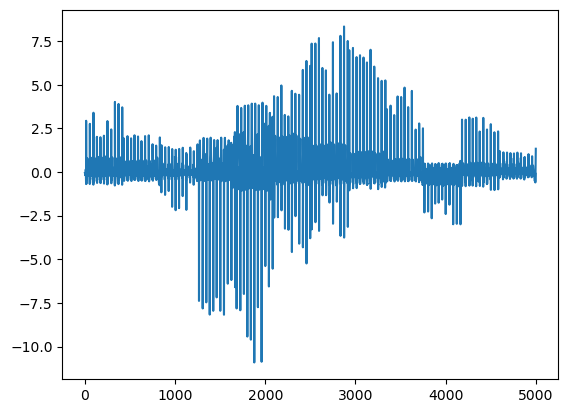

In [40]:
plt.plot(x_signal_m[caseid_m==c_train[0],:,0].flatten())

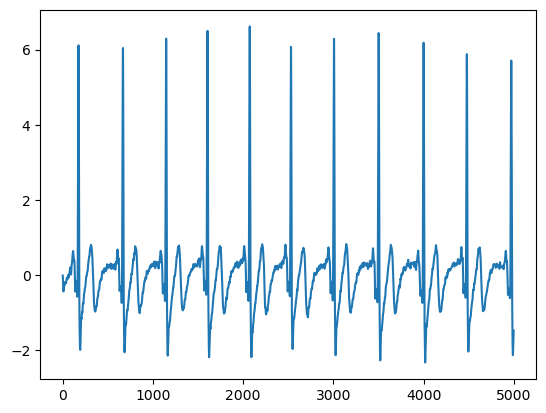

In [41]:
plt.plot(x_train[0,:,0].flatten())

In [13]:
np.sum(np.isnan(x_signal))

0

# Augmentation

In [2]:
import numpy as np
from tqdm import tqdm

class lead_extractor:
    """
    used to select specific leads or random choice of configurations

    Twelve leads: I, II, III, V1, V2, V3, V4, V5, V6, aVR, aVL, aVF, 
    Six leads: I, II, V1, V3, V4, V6
    Four leads: III, V1, V2, aVL # I, II, III, V2
    Three leads: I, II, V2
    Two leads: I, II

    """
    L2 = np.array([1,1,0,0,0,0,0,0,0,0,0,0])
    L3 = np.array([1,1,0,0,0,0,0,1,0,0,0,0])
    L4 = np.array([0,0,1,1,1,0,0,0,0,0,1,0]) #([1,1,1,0,0,0,0,1,0,0,0,0])
    L6 = np.array([1,1,0,1,0,1,1,0,1,0,0,0])
    L8 = np.array([1,1,0,1,0,1,1,1,1,0,1,0])
    L12 = np.array([1,1,1,1,1,1,1,1,1,1,1,1])

    @staticmethod
    def get (x,num_leads):
        if num_leads==None:
            # random choice output
            num_leads = random.choice([12,8,6,4,3,2])

        if num_leads==12:
            # Twelve leads: I, II, III, aVR, aVL, aVF, V1, V2, V3, V4, V5, V6
            return x

        if num_leads==8:
            # Six leads: I, II, III, aVL, aVR, aVF
            x = x * lead_extractor.L8
            return x

        if num_leads==6:
            # Six leads: I, II, III, aVL, aVR, aVF
            x = x * lead_extractor.L6
            return x

        if num_leads==4:
            # Six leads: I, II, III, V2
            x = x * lead_extractor.L4
            return x

        if num_leads==3:
            # Three leads: I, II, V2
            x = x * lead_extractor.L3
            return x

        if num_leads==2:
            # Two leads: II, V5
            x = x * lead_extractor.L2
            return x
        raise Exception("invalid-leads-number")

In [1]:
def aug_generator(x_train, feat_train, y_train, c_train, g_train):
    x_train_, feat_train_, y_train_, c_train_, g_train_ = [], [], [], [], []
    for i in tqdm(range(x_train.shape[0])):
        x_train_.append(x_train[i])
        feat_train_.append(feat_train[i])
        y_train_.append(y_train[i])
        c_train_.append(c_train[i])
        g_train_.append(g_train[i])

        x_train_.append(lead_extractor.get(x_train[i], 8))
        feat_train_.append(feat_train[i])
        y_train_.append(y_train[i])
        c_train_.append(c_train[i])
        g_train_.append(g_train[i])    

        x_train_.append(lead_extractor.get(x_train[i], 6))
        feat_train_.append(feat_train[i])
        y_train_.append(y_train[i])
        c_train_.append(c_train[i])
        g_train_.append(g_train[i])  

        x_train_.append(lead_extractor.get(x_train[i], 4))
        feat_train_.append(feat_train[i])
        y_train_.append(y_train[i])
        c_train_.append(c_train[i])
        g_train_.append(g_train[i]) 

    x_train_ = np.array(x_train_, np.float32)
    feat_train_ = np.array(feat_train_, np.float32)
    y_train_ = np.array(y_train_, np.float32)
    c_train_ = np.array(c_train_)
    g_train_ = np.array(g_train_, np.float32)

    print(f'x shape: {x_train_.shape}')
    print(f'feat shape: {feat_train_.shape}')
    print(f'y shape: {y_train_.shape}')
    
    return x_train_, feat_train_, y_train_, c_train_, g_train_

### adult

In [3]:
# lead 12, 8, 6, 4, 3 조합

SRATE = 500
ECG_FILT = 'bandpass'
TRAIN = 'train'
ADULT = 'adult'
NORM = 'z-norm'


hyper_path = f'SRATE{SRATE}_ECG-{ECG_FILT}_{NORM}_{ADULT}_{TRAIN}'
input_path = f'dataset/{hyper_path}/signal+features/'

with np.load(input_path+'x.npz', allow_pickle=True) as f:
    x_train = f['x_train']
    x_test = f['x_test']    

with np.load(input_path+'feats.npz', allow_pickle=True) as f:
    feat_train = f['feat_train']
    feat_test = f['feat_test']
        
with np.load(input_path+'y.npz', allow_pickle=True) as f:
    y_train = f['y_train']
    y_test = f['y_test']
    
with np.load(input_path+'c.npz', allow_pickle=True) as f:
    c_train = f['c_train']
    c_test = f['c_test']  
    
with np.load(input_path+'g.npz', allow_pickle=True) as f:
    g_train = f['g_train']
    g_test = f['g_test']        
    
print(f'x train shape: {x_train.shape}')
print(f'feat train shape: {feat_train.shape}')
print(f'x test shape: {x_test.shape}')
print(f'feat test shape: {feat_test.shape}')
print(f'x train shape: {x_train.shape}')
print(f'feat train shape: {feat_train.shape}')
print(f'x test shape: {x_test.shape}')
print(f'feat test shape: {feat_test.shape}')

x train shape: (27824, 5000, 12)
feat train shape: (27824, 55)
x test shape: (6962, 5000, 12)
feat test shape: (6962, 55)
x train shape: (27824, 5000, 12)
feat train shape: (27824, 55)
x test shape: (6962, 5000, 12)
feat test shape: (6962, 55)


In [5]:
x_train_, feat_train_, y_train_, c_train_, g_train_ = aug_generator(x_train, feat_train, y_train, c_train, g_train)
x_test_, feat_test_, y_test_, c_test_, g_test_ = aug_generator(x_test, feat_test, y_test, c_test, g_test)

100%|██████████| 27824/27824 [00:20<00:00, 1372.55it/s]


x shape: (111296, 5000, 12)
feat shape: (111296, 55)
y shape: (111296,)


100%|██████████| 6962/6962 [00:03<00:00, 2057.59it/s]


x shape: (27848, 5000, 12)
feat shape: (27848, 55)
y shape: (27848,)


In [7]:
import os

hyper_path = f'SRATE{SRATE}_ECG-{ECG_FILT}_{NORM}_{ADULT}_{TRAIN}'
input_path = f'dataset/{hyper_path}/signal+features+aug(12,8,6,4)'
if not os.path.exists(input_path):
    os.mkdir(input_path)  

print('saving...', end='', flush=True)
np.savez_compressed(input_path+'/x.npz', x_train=x_train_, x_test=x_test_)
np.savez_compressed(input_path+'/feats.npz', feat_train=feat_train_, feat_test=feat_test_)
np.savez_compressed(input_path+'/y.npz', y_train=y_train_, y_test=y_test_)
np.savez_compressed(input_path+'/c.npz', c_train=c_train_, c_test=c_test_)
np.savez_compressed(input_path+'/g.npz', g_train=g_train_, g_test=g_test_)

saving...

### child

In [8]:
# lead 12, 8, 6, 4, 3 조합

SRATE = 500
ECG_FILT = 'bandpass'
TRAIN = 'train'
ADULT = 'child'
NORM = 'z-norm'


hyper_path = f'SRATE{SRATE}_ECG-{ECG_FILT}_{NORM}_{ADULT}_{TRAIN}'
input_path = f'dataset/{hyper_path}/signal+features/'

with np.load(input_path+'x.npz', allow_pickle=True) as f:
    x_train = f['x_train']
    x_test = f['x_test']    

with np.load(input_path+'feats.npz', allow_pickle=True) as f:
    feat_train = f['feat_train']
    feat_test = f['feat_test']
        
with np.load(input_path+'y.npz', allow_pickle=True) as f:
    y_train = f['y_train']
    y_test = f['y_test']
    
with np.load(input_path+'c.npz', allow_pickle=True) as f:
    c_train = f['c_train']
    c_test = f['c_test']  
    
with np.load(input_path+'g.npz', allow_pickle=True) as f:
    g_train = f['g_train']
    g_test = f['g_test']        
    
print(f'x train shape: {x_train.shape}')
print(f'feat train shape: {feat_train.shape}')
print(f'x test shape: {x_test.shape}')
print(f'feat test shape: {feat_test.shape}')
print(f'x train shape: {x_train.shape}')
print(f'feat train shape: {feat_train.shape}')
print(f'x test shape: {x_test.shape}')
print(f'feat test shape: {feat_test.shape}')

x train shape: (7021, 5000, 12)
feat train shape: (7021, 55)
x test shape: (1756, 5000, 12)
feat test shape: (1756, 55)
x train shape: (7021, 5000, 12)
feat train shape: (7021, 55)
x test shape: (1756, 5000, 12)
feat test shape: (1756, 55)


In [9]:
x_train_, feat_train_, y_train_, c_train_, g_train_ = aug_generator(x_train, feat_train, y_train, c_train, g_train)
x_test_, feat_test_, y_test_, c_test_, g_test_ = aug_generator(x_test, feat_test, y_test, c_test, g_test)

100%|██████████| 7021/7021 [00:03<00:00, 2026.42it/s]


x shape: (28084, 5000, 12)
feat shape: (28084, 55)
y shape: (28084,)


100%|██████████| 1756/1756 [00:00<00:00, 2040.52it/s]


x shape: (7024, 5000, 12)
feat shape: (7024, 55)
y shape: (7024,)


In [10]:
import os

hyper_path = f'SRATE{SRATE}_ECG-{ECG_FILT}_{NORM}_{ADULT}_{TRAIN}'
input_path = f'dataset/{hyper_path}/signal+features+aug(12,8,6,4)'
if not os.path.exists(input_path):
    os.mkdir(input_path)  

print('saving...', end='', flush=True)
np.savez_compressed(input_path+'/x.npz', x_train=x_train_, x_test=x_test_)
np.savez_compressed(input_path+'/feats.npz', feat_train=feat_train_, feat_test=feat_test_)
np.savez_compressed(input_path+'/y.npz', y_train=y_train_, y_test=y_test_)
np.savez_compressed(input_path+'/c.npz', c_train=c_train_, c_test=c_test_)
np.savez_compressed(input_path+'/g.npz', g_train=g_train_, g_test=g_test_)

saving...

# Validation

In [100]:
SRATE = 500
TRAIN = 'train'
ADULT = 'adult'
NORM = 'z-norm'
LEADS = np.arange(12)
ECG_FILT = 'bandpass'

df_sub = pd.read_csv(f'ECG_{ADULT}_age_{TRAIN}.csv')
for idx, row in tqdm(df_sub.iterrows(), total=df_sub.shape[0]):
    if 'adult' in row['FILENAME']:
        ADULT = 'adult'
        model = model_adult_male if row['GENDER'] == 'MALE' else model_adult_female
    else:
        ADULT = 'child'
        model = model_child_male if row['GENDER'] == 'MALE' else model_child_female
          
    file_path = f'dataset/ECG_{ADULT}_numpy_{TRAIN}'
    caseid = row['FILENAME']
    
    seg_ecg = np.load(f'{file_path}/{caseid}.npy')
    seg_ecg = ECG_filter(pd.DataFrame(seg_ecg).fillna(method='ffill', axis=0).fillna(method='bfill', axis=0).values.flatten(), method=ECG_FILT, srate=SRATE)
    
    # invalid ecg
    if len(np.unique(seg_ecg)) == 1:
        df_sub.loc[idx, 'AGE'] = 65 if ADULT == 'adult' else 4
        continue
    
    # NORM = z-norm
    ecg_input = []
    for i in LEADS:
        ecg_input.append(stats.zscore(seg_ecg[5000*i:5000*(i+1)]))

    df_sub.loc[idx, 'AGE'] = model.predict(np.array(ecg_input).reshape(1,12,5000).transpose((0,2,1)), verbose=0).flatten()[0]   

  0%|          | 0/34907 [00:00<?, ?it/s]


NameError: name 'model_adult_male' is not defined